### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

# for clearing cell output for prints
from IPython.display import clear_output

#### Defining Time Matrix

In [2]:
# Loading the time matrix which acts as traffic data to help calculate time taken to travel between two locations
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
states_to_track = {}

In [4]:
def initialise_tracking_states():
    random_states = random.sample(env.state_space,5)   # 5 Random State from State space
    random_actions = random.sample(env.action_space,5) # 5 Random Actions from State space
    for i in range(5):
        states_to_track[random_states[i]]={random_actions[i]:[]} # Join together, We will Append Predicted Q Values here.

In [5]:
def save_tracking_states():
    for state in states_to_track.keys():
        for action in states_to_track[state].keys():
            predicted_q_value = agent.prediction(state,[action])   # Predict Q Value for the particular State Action pair
            states_to_track[state][action].append(predicted_q_value) # Append Predicted Q Value to list for tracking

In [6]:
# Function to save the Q-dictionary and other objects as a pickle files
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [7]:
class DQNAgent:
    def __init__(self):
        
        self.state_size = env.state_size_arch_1  # State size for Architecture 1 ( m + t + d + m + m )
        self.action_size = env.action_size  # Action Space Size

        # Hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001
        self.epsilon_max = 1
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        self.batch_size = 32     
        
        # Replay memory using deque
        self.memory = deque(maxlen=2000)

        # Create DQN Model
        self.model = self.build_model()


        # Create DQN Model
    def build_model(self):
        model = Sequential()
        model.add(Dense(units=200,input_dim=self.state_size,activation='relu',name="DHLayer-1"))
        model.add(Dense(units=150,activation='relu',name="DHLayer-2"))
        model.add(Dense(units=100,activation='relu',name="DHLayer-3"))
        model.add(Dense(units=1,activation='linear',name="Output"))
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        print(model.summary())
        return model
        
        #Prediction Function to Take state and list of Actions and predict Q values for corresponding State-Action pairs.
    def prediction(self, state, action):
        X_test = np.zeros((len(action), self.state_size)) # Initialise input Matrix of Action(s) x State
        for i in range(len(action)):
            state_action_encd = env.state_encod_arch1(state, action[i]) # Encode State-actions pairs
            X_test[i,:] = state_action_encd   # Update correspoing Actions Input Matrix row
        prediction = self.model.predict(X_test,verbose=0) # Predict Q Values for all State-Action Pairs
        prediction = prediction.reshape(len(action)) # Reshape output to Vector of Size input Action(s)
        return prediction


    def get_action(self, state, episode):
        #Epsilon Value with time based decay
        epsilon = self.epsilon_min + (self.epsilon_max-self.epsilon_min) * np.exp(-self.epsilon_decay * episode)
        
        # Get Trip Requests based on poisson distributions and Current State
        possible_actions_index, possible_actions = env.requests(state)
        
        z = np.random.rand()   # Random z value between 0 and 1
        

        if z > epsilon: # if epsilon value is small
            
            # Exploitation
            predicted_q_values = self.prediction(state,possible_actions) # Get Q values for Possible Actions
            max_q_value_index = np.argmax(predicted_q_values) # Chose Max Q Value (Max Expected Reward Action)
            action = possible_actions[max_q_value_index] # Choose that Action
            
        else: # if epsilon value is large
            
            # Exploration         
            action = random.choice(possible_actions) # Choose random action from list of possible actions
        
        return action, epsilon
            
    

    def append_sample(self, state, action, reward, next_state, terminal_state):
       
        # save sample <s,a,r,s',terminal> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal_state))
    

    # Pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size: # If enough samples in memory for training
            
            # Pick Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            # Initialise Input matricies
            update_input = np.zeros((self.batch_size,self.state_size))
            update_output = np.zeros((self.batch_size,self.action_size))
            
            
            # Initialise empty lists for tracking data used in calculating culminative rewards
            actions, rewards, terminals = [], [], [] 
                       
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state = mini_batch[i] # Choose a memory from Mini-Batch
                
                rewards.append(reward)                                # Update rewards
                actions.append(env.action_space.index(action))        # Update actions
                terminals.append(terminal_state)                      # Update terminal states
                
                update_input[i] = env.state_encod_arch1(state,action)               # Input : State and Action Pair Encoding
                update_output[i,:] = self.prediction(next_state,env.action_space)   # Output: Expected Q Value for Next State and all possible Actions
                
            target = np.zeros((self.batch_size)) # y Vector for DQN
            
            for i in range(self.batch_size):
                
                if terminals[i]:
                    target[i] = rewards[i]  # If Terminal State, update y with Reward
                
                else:
                    # If not Terminal State
                    # update y with Reward + discounted next state expected reward
                    target[i] = rewards[i] + self.discount_factor * (np.amax(update_output[i])) 
            
            self.model.fit(update_input, target, epochs=1, batch_size=self.batch_size, verbose=0) # Train the model for 1 epoch
    
    # Load Exisiting model weights for further training
    def load(self, name):
        self.model.load_weights(name)
    # Save model weights    
    def save(self, name):
        self.model.save_weights(name)

In [8]:
Episodes = 1000 # Ideally, 40,000 should give us good results based on Epsilon decay params. 
# I had low Computational power hence trained it for 1000 only.

### DQN block

In [9]:
env = CabDriver()        # Initalise environment

agent = DQNAgent()       # Initalise Agent

initialise_tracking_states() #  Initalise tracking states ( to be done after env since it uses state and action space from env )

avg_rewards, total_rewards, avg_epsilon = [] , [] , []  #Initalise empty list to help tracking and graphing

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DHLayer-1 (Dense)           (None, 200)               9400      
                                                                 
 DHLayer-2 (Dense)           (None, 150)               30150     
                                                                 
 DHLayer-3 (Dense)           (None, 100)               15100     
                                                                 
 Output (Dense)              (None, 1)                 101       
                                                                 
Total params: 54,751
Trainable params: 54,751
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
start_time = time.time()   # Start Time to calculate training time

for episode in range(Episodes):
    
    _,_,state = env.reset() # Get Initial State
    
    total_reward = 0  # Total Episode Reward
    trip_count = 0    # Number of Trips taken in this episode
    total_epsilon = 0 # Total Episode Epsilon for calculating average
    
    terminal_state = False
    
    while not terminal_state:
        
        action, epsilon = agent.get_action(state, episode) # Get Action for Current State
        
        reward = env.reward_func(state, action, Time_matrix) # Calculate Reward for Current State Action pair
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix) # Get Next State and Terminal State flag
        
        agent.append_sample(state, action, reward, next_state, terminal_state) # Save to Memory
        
        total_reward += reward            # Update Episode Reward
        total_epsilon += epsilon          # Update Episode Epsilon
        trip_count += 1                   # Update Episode Trip Count
        
        state = next_state                # Update Current State as next State
        
        print(f"Episode {episode} : Trip {trip_count}")
        
        clear_output(wait=True) # Clear Output ( Else too many lines of output and Notebook freezes )
    
    agent.train_model() # Train the Model after every episode
    
    total_rewards.append(total_reward)                      # Append Total Episode Reward
    
    avg_rewards.append((total_reward/trip_count))           # Append Average Episode Reward
    
    avg_epsilon.append((total_epsilon/trip_count))          # Append Average Episode Epsilon
    
    
    print(f"Episode:{episode} Score: {total_reward} Memory Length: {len(agent.memory)} Epsilon: {epsilon}")
    
    # Every 200 Episodes, save the model
    if episode % 200 == 0:
            agent.save("./cab_driver_arch1.h5")

    # Every 25 Episodes, Save Average Rewards and States Tracked
    if episode % 25 == 0:
        save_obj(avg_rewards,'Rewards_arch1')   
        save_tracking_states()
        save_obj(states_to_track,'States_tracked_arch1')   
        
    # Every 1000 Episodes, Plot Total Rewards, Average Rewards and Average Epsilon to track model performance
    if episode % 1000 == 0 and episode != 0:
        
        plt.subplots(figsize=(15,5))
        
        plt.subplot(1,3,1)
        plt.plot(list(range(len(avg_rewards))), avg_rewards)
        plt.title("Average Rewards")
        plt.ylabel("Rewards")
        plt.xlabel("Episodes")
        
        plt.subplot(1,3,2)
        plt.plot(list(range(len(total_rewards))), total_rewards)
        plt.title("Total Rewards")
        plt.ylabel("Rewards")
        plt.xlabel("Episodes")
      
        plt.subplot(1,3,3)
        plt.plot(list(range(len(avg_epsilon))), avg_epsilon)
        plt.title("Average Epsilon")
        plt.ylabel("Epsilon")
        plt.xlabel("Episodes")
        
        # space between the plots
        plt.tight_layout()

        # show plot
        plt.show()
        
        # time.sleep(30)   # Sleep time to wait and see graph before the output is cleared
        
end_time = time.time()  # End Time of training time

print(f"Time Taken for Training: {end_time - start_time}")        

Episode:999 Score: -104.0 Memory Length: 2000 Epsilon: 0.7410405020776712
Time Taken for Training: 19525.59701704979


#### Plotting Graphs

Text(0.5, 0, 'Episodes')

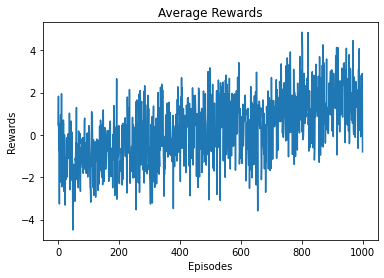

In [11]:
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.title("Average Rewards")
plt.ylabel("Rewards")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

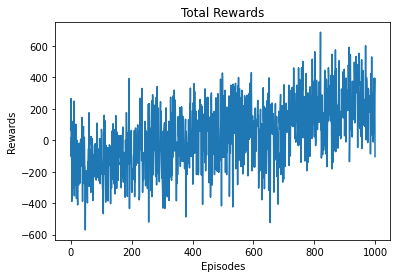

In [12]:
plt.plot(list(range(len(total_rewards))), total_rewards)
plt.title("Total Rewards")
plt.ylabel("Rewards")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

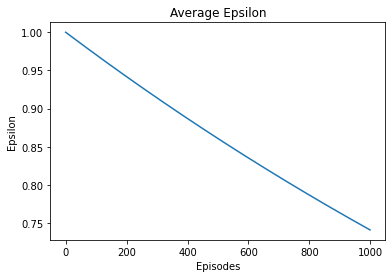

In [13]:
plt.plot(list(range(len(avg_epsilon))), avg_epsilon)
plt.title("Average Epsilon")
plt.ylabel("Epsilon")
plt.xlabel("Episodes")

### Tracking Convergence

In [14]:
states_to_track

{(3,
  3,
  5): {(2, 0): [array([0.16330616], dtype=float32),
   array([-0.43942788], dtype=float32),
   array([-0.77894765], dtype=float32),
   array([4.327155], dtype=float32),
   array([88.12016], dtype=float32),
   array([242.87494], dtype=float32),
   array([208.11696], dtype=float32),
   array([202.67099], dtype=float32),
   array([230.18018], dtype=float32),
   array([182.34027], dtype=float32),
   array([240.25177], dtype=float32),
   array([299.14374], dtype=float32),
   array([430.4039], dtype=float32),
   array([252.49602], dtype=float32),
   array([300.08948], dtype=float32),
   array([308.77347], dtype=float32),
   array([226.37082], dtype=float32),
   array([244.18616], dtype=float32),
   array([310.0863], dtype=float32),
   array([283.83356], dtype=float32),
   array([298.40097], dtype=float32),
   array([339.1929], dtype=float32),
   array([250.24313], dtype=float32),
   array([263.69467], dtype=float32),
   array([289.3477], dtype=float32),
   array([401.61078], dtype=

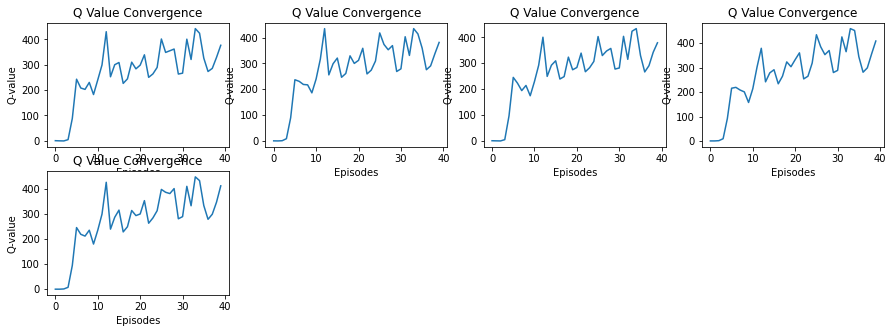

In [15]:
# Average Q Values should increase and then flatten out after a while

plt.figure(0, figsize=(15,5))
i=1
for state in states_to_track.keys():
    for action in states_to_track[state].keys():
        states_to_track[state][action]
        xaxis = np.asarray(range(len(states_to_track[state][action])))
        plt.subplot(2,4,i)
        plt.plot(xaxis,np.asarray(states_to_track[state][action]))
        plt.title("Q Value Convergence")
        plt.ylabel("Q-value")
        plt.xlabel("Episodes")
        i+=1

plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [16]:
epsilon_max = 1.0
epsilon_decay = 0.0003
epsilon_min = 0.00000001
episodes = 1000

time = np.arange(0,episodes)
epsilon = []
for i in range(0,episodes):
    epsilon.append(epsilon_min + (epsilon_max - epsilon_min) * np.exp(-epsilon_decay*i))

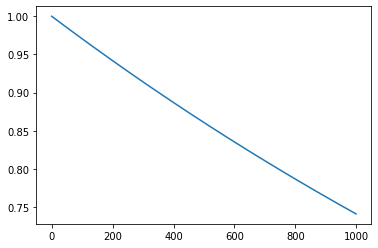

In [17]:
plt.plot(time, epsilon)
plt.show()